In [2]:
import numpy as np
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt
import pdb
import os
from PIL import Image

In [3]:
def read_images_from_folder(folder_path):
    images = []
    image_names = []
    supported_formats = '.jpg'
    for filename in os.listdir(folder_path):
        if filename.endswith(supported_formats):
            img_path = os.path.join(folder_path, filename)
            try:
                with Image.open(img_path) as img:
                    images.append(np.array(img))
                    image_name = os.path.splitext(filename)[0]  # Remove the file extension
                    image_names.append(int(image_name))  # Convert the filename to integer
            except IOError:
                print(f"Failed to open {img_path}")
            except ValueError:
                print(f"Filename {filename} is not a valid integer. Skipping.")

    return np.array(images), image_names


<function matplotlib.pyplot.show(close=None, block=None)>

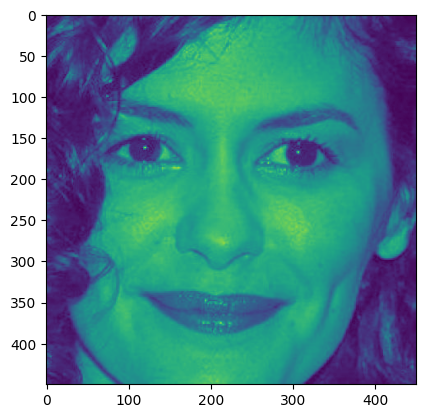

In [4]:
folder_path = r"G:\Challenge\resnet_grayscale\set_1"
images, image_names = read_images_from_folder(folder_path)

plt.imshow(images[0])
plt.show

In [5]:
import pandas as pd

file_path = r"G:\Challenge\train.csv"
data = pd.read_csv(file_path, header=None, skiprows=1)
third_column_data = data.iloc[:, 2]

y_train = []

for i in image_names:
    y_train.append(third_column_data[i])

for j in range (0,5):
    print(y_train[j], image_names[j])

y_train = np.array(y_train)
image_names = np.array(image_names)

print(y_train.shape[0])
print(image_names.shape[0])

Audrey Tautou 0
Albert Finney 10
Alex Pettyfer 10009
Art Carney 10020
Albert Brooks 10031
5956
5956


In [6]:
import pandas as pd

# Load the CSV file
csv_path = r"G:\Challenge\category.csv"
df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame to understand its structure
df.head()

name_to_integer = dict(zip(df['Category'], df['Unnamed: 0']))

# Function to convert an array of names into integers
def convert_names_to_integers(names, mapping):
    return [mapping[name] if name in mapping else None for name in names]


lable_train = convert_names_to_integers(y_train, name_to_integer)
for j in range (0,5):
    print(lable_train[j], image_names[j])



87 0
66 10
76 10009
0 10020
72 10031


In [7]:
num_classes = 100
input_shape = (450, 450, 1)

images = np.expand_dims(images, axis=-1)

# images = images.astype("float32") /255
print("x_train shape:", images.shape)

x_train shape: (5956, 450, 450, 1)


In [8]:
lable_train = np.array(lable_train)
images[0].shape
print(lable_train.dtype)


int32


In [9]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, stride=1, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', activation='relu')
        self.conv2 = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')
        self.adjust_input_shape = layers.Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same')
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        residual = self.adjust_input_shape(inputs)
        x = layers.add([x, residual])  # Add the adjusted input (residual) to the output
        return layers.Activation('relu')(x)

model = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    ResidualBlock(64),
    layers.MaxPooling2D(pool_size=(2, 2)),
    ResidualBlock(128),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [10]:
sub_images = np.array_split(images, 8)  # Replace 8 with the number of subsets you want
sub_lable_train = np.array_split(lable_train, 8)
loadflag = 0

In [11]:
epochs_per_subset = 10  # Epochs to train on each subset
device = "/gpu:0"

for epoch in range(epochs_per_subset):
    for i, (subset, label_subset) in enumerate(zip(sub_images, sub_lable_train)):
        print(f"Training on subset {i+1}, epoch {epoch+1}")

        # Normalize the image data
        subset = subset.astype("float32") / 255

        # Compile the model for the first subset of the first epoch
        if loadflag == 0:
            if i == 0 and epoch == 0:
                model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        else:
            if i == 0 and epoch == 0:
                model.load('G:/Challenge/resnet_grayscale/final_trained_model.keras')

        # Fit the model on the current subset
        model.fit(subset, label_subset, batch_size=32)

# After training on all subsets for all epochs, save the model
model.save('G:\Challenge\resnet_grayscale\final_trained_model.keras')

Training on subset 1, epoch 1
24/24 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.0124 - loss: 11.0023
Training on subset 2, epoch 1
24/24 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.0068 - loss: 4.6050
Training on subset 3, epoch 1
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.0079 - loss: 4.6060
Training on subset 4, epoch 1
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.0118 - loss: 4.6051
Training on subset 5, epoch 1
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.0084 - loss: 4.6043
Training on subset 6, epoch 1
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.0059 - loss: 4.6050
Training on subset 7, epoch 1
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.0064 - loss: 4.6045
Training on subset 8, epoch 1
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.0084 - loss: 4.6047
Training on subset 1, epoch 2
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.0198 - loss: 4.6006
Training on subset 2, epoch 2
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - a

OSError: [Errno 22] Invalid argument: 'G:\\Challenge\resnet_grayscale\x0cinal_trained_model.keras'

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at C:\Users\lemon\AppData\Local\Temp\ipykernel_15304\2022620616.py (5)[0m
[1m
File "C:\Users\lemon\AppData\Local\Temp\ipykernel_15304\2022620616.py", line 5:[0m
[1m
[1m@jit(target_backend='cuda')
[0m[1m^[0m[0m 

This error may have been caused by the following argument(s):
- argument 3: [1mCannot determine Numba type of <class 'keras.src.models.sequential.Sequential'>[0m
